## DeepExplain - Tensorflow example
### MNIST with a 2-layers MLP

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

# Download and import MNIST data
tmp_dir = tempfile.gettempdir()
mnist = input_data.read_data_sets(tmp_dir, one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
# Parameters
learning_rate = 0.005
num_steps = 2000
batch_size = 128

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1], mean=0.0, stddev=0.05)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=0.0, stddev=0.05)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes], mean=0.0, stddev=0.05))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [5]:
# Create and train model
def model(x, act=tf.nn.relu):  # < different activation functions lead to different explanations
    layer_1 = act(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = act(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
logits = model(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Train
def input_transform (x): 
    return (x - 0.5) *  2

sess = tf.Session()

# Run the initializer
sess.run(init)

for step in range(1, num_steps+1):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = input_transform(batch_x)
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    if step % 100 == 0 or step == 1:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                             Y: batch_y})
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))

print("Done")

# Calculate accuracy for MNIST test images
test_x = input_transform(mnist.test.images)
test_y = mnist.test.labels

print("Test accuracy:", \
    sess.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step 1, Minibatch Loss= 2.9182, Training Accuracy= 0.203
Step 100, Minibatch Loss= 0.3144, Training Accuracy= 0.898
Step 200, Minibatch Loss= 0.2018, Training Accuracy= 0.938
Step 300, Minibatch Loss= 0.1873, Training Accuracy= 0.938
Step 400, Minibatch Loss= 0.1176, Training Accuracy= 0.969
Step 500, Minibatch Loss= 0.0843, Training Accuracy= 0.984
Step 600, Minibatch Loss= 0.0608, Training Accuracy= 0.992
Step 700, Minibatch Loss= 0.0959, Training Accuracy= 0.969
Step 800, Minibatch Loss= 0.1378, Training Accuracy= 0.961
Step 900, Minibatch Loss= 0.0721, Training Accuracy= 0.977
Step 1000, Minibatch Loss= 0.0855, Training Accuracy= 0.984
Step 1100, Minibatch Loss= 0.2338, Training Accuracy= 0.906
Step 1200, Minibatch Loss= 0.0987, Training Accuracy= 0.961
Step 1300, Minibatch Loss= 0.0635, Traini

### Use DeepExplain to find attributions for each input pixel

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Done


/home/ax/miniconda3/envs/masterThesis/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


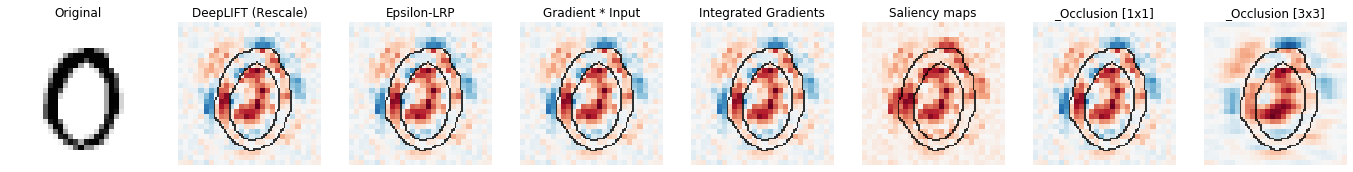

In [6]:
# Import DeepExplain
from deepexplain.tensorflow import DeepExplain
from utils import plot, plt
%matplotlib inline

# Define the input to be tested
test_idx = 13
xi = test_x[[test_idx]]
yi = test_y[test_idx] 

# Create a DeepExplain context. 
# IMPORTANT: the network must be created within this context.
# In this example we have trained the network before, so we call `model(X)` to 
# recreate the network graph using the same weights that have been already trained.
with DeepExplain(session=sess) as de:
    logits = model(X)
    # We run `explain()` several time to compare different attribution methods
    attributions = {
        # Gradient-based
        'Saliency maps':        de.explain('saliency', logits * yi, X, xi),
        'Gradient * Input':     de.explain('grad*input', logits * yi, X, xi),
        'Integrated Gradients': de.explain('intgrad', logits * yi, X, xi),
        'Epsilon-LRP':          de.explain('elrp', logits * yi, X, xi),
        'DeepLIFT (Rescale)':   de.explain('deeplift', logits * yi, X, xi),
        #Perturbation-based
        '_Occlusion [1x1]':      de.explain('occlusion', logits * yi, X, xi),
        '_Occlusion [3x3]':      de.explain('occlusion', logits * yi, X, xi, window_shape=(3,))
    }
    print ('Done')

# Plot attributions
n_cols = len(attributions) + 1
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(3*n_cols, 3))
plot(xi.reshape(28, 28), cmap='Greys', axis=axes[0]).set_title('Original')
for i, method_name in enumerate(sorted(attributions.keys())):
    plot(attributions[method_name].reshape(28,28), xi = xi.reshape(28, 28), axis=axes[1+i]).set_title(method_name)